## LLM performance

In [1]:
with open("hatespeech_predictions.txt", "r") as f:
    outputs = [int(line.strip()) for line in f.readlines()]

In [74]:
import datasets

data = datasets.load_from_disk('2000_sampled_hatespeech')
labels = data['label']

# calculate overall accuracy
correct = 0
total = 0
for i in range(len(outputs)):
    total += 1
    if outputs[i] == labels[i]:
        correct += 1
print("Overall accuracy: {}".format(correct / total))

# calculate accuracy for each class
pos_correct = 0
pos_total = 0
neg_correct = 0
neg_total = 0
for i in range(len(outputs)):
    if labels[i] == 1:
        pos_total += 1
        if outputs[i] == labels[i]:
            pos_correct += 1
    else:
        neg_total += 1
        if outputs[i] == labels[i]:
            neg_correct += 1

print("Positive accuracy: ", pos_correct / pos_total)
print("Negative accuracy: ", neg_correct / neg_total)


Overall accuracy: 0.8415
Positive accuracy:  0.65625
Negative accuracy:  0.8648648648648649


In [108]:
pos_total

43

In [75]:
pos_correct, pos_total-pos_correct, pos_total, neg_correct, neg_total-neg_correct, neg_total

(147, 77, 224, 1536, 240, 1776)

## LLM labels as proxy

#### dataset & library import

In [76]:
# plot the accuracy changes as we adjust the number of samples
import matplotlib.pyplot as plt
import numpy as np
# beautify the plot
plt.style.use('seaborn-darkgrid')

/tmp/ipykernel_669187/221098722.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


#### td-idf as word embeddings

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer

texts = data["text"]  # list of texts to classify
labels = data["label"]  # list of texts to classify

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 1), lowercase=True)

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

with open("hatespeech_predictions.txt") as f:
    llama_labels = [int(line) for line in f.readlines()]

# Split the data into training and test sets
X_train_proxy, X_test_proxy, y_train_proxy, y_test_proxy = train_test_split(texts, llama_labels, test_size=0.2, random_state=42)
X_train_proxy = vectorizer.fit_transform(X_train_proxy)
X_test_proxy = vectorizer.transform(X_test_proxy)

_, _, _, y_test_gold = train_test_split(texts, labels, test_size=0.2, random_state=42)
baseline_acc = accuracy_score(y_test_proxy, y_test_gold)


# Train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train_proxy, y_train_proxy)

# Make predictions on the test set
y_pred_proxy = classifier.predict(X_test_proxy)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test_gold, y_pred_proxy)
print("Accuracy:", accuracy)

# calculate accuracy for each class
pos_correct = 0
pos_total = 0
neg_correct = 0
neg_total = 0
for i in range(len(y_pred_proxy)):
    if y_test_gold[i] == 1:
        pos_total += 1
        if y_pred_proxy[i] == y_test_gold[i]:
            pos_correct += 1
    else:
        neg_total += 1
        if y_pred_proxy[i] == y_test_gold[i]:
            neg_correct += 1

print("Positive accuracy: ", pos_correct / pos_total)
print("Negative accuracy: ", neg_correct / neg_total)

Accuracy: 0.8925
Positive accuracy:  0.046511627906976744
Negative accuracy:  0.9943977591036415


In [85]:
pos_correct, pos_total-pos_correct, pos_total, neg_correct, neg_total-neg_correct, neg_total

(2, 41, 43, 355, 2, 357)

In [86]:
import eli5

eli5.show_weights(estimator=classifier, 
                  feature_names= list(vectorizer.get_feature_names_out()),
                 top=(10, 10))

Weight?,Feature
+2.468,jews
+2.451,white
+2.105,whites
+1.845,negro
+1.436,jew
+1.399,race
+1.389,negroes
+1.336,jewish
+1.262,need
+1.181,africa


#### sentence-bert as word embeddings

In [87]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

texts = data["text"]  # list of texts to classify
labels = data["label"]  # list of texts to classify

# Encode the training set
texts = model.encode(texts)

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

with open("hatespeech_predictions.txt") as f:
    llama_labels = [int(line) for line in f.readlines()]
    
# Split the data into training and test sets
X_train_proxy, X_test_proxy, y_train_proxy, y_test_proxy = train_test_split(texts, llama_labels, test_size=0.2, random_state=42)
_, _, _, y_test_gold = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train_proxy, y_train_proxy)

# Make predictions on the test set
y_pred_proxy = classifier.predict(X_test_proxy)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test_gold, y_pred_proxy)
print("Accuracy:", accuracy)

# calculate accuracy for each class
pos_correct = 0
pos_total = 0
neg_correct = 0
neg_total = 0
for i in range(len(y_pred_proxy)):
    if y_test_gold[i] == 1:
        pos_total += 1
        if y_pred_proxy[i] == y_test_gold[i]:
            pos_correct += 1
    else:
        neg_total += 1
        if y_pred_proxy[i] == y_test_gold[i]:
            neg_correct += 1

print("Positive accuracy: ", pos_correct / pos_total)
print("Negative accuracy: ", neg_correct / neg_total)

Accuracy: 0.885
Positive accuracy:  0.32558139534883723
Negative accuracy:  0.9523809523809523


In [89]:
pos_correct, pos_total-pos_correct, pos_total, neg_correct, neg_total-neg_correct, neg_total

(14, 29, 43, 340, 17, 357)

### RQ - Confidence threshold

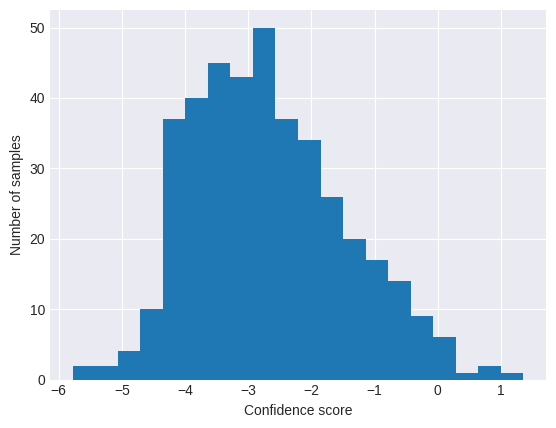

In [96]:
# plot a bar chart of the distribution of the confidence scores
plt.hist(classifier.decision_function(X_test_proxy), bins=20)
plt.xlabel("Confidence score")
plt.ylabel("Number of samples")
plt.show()


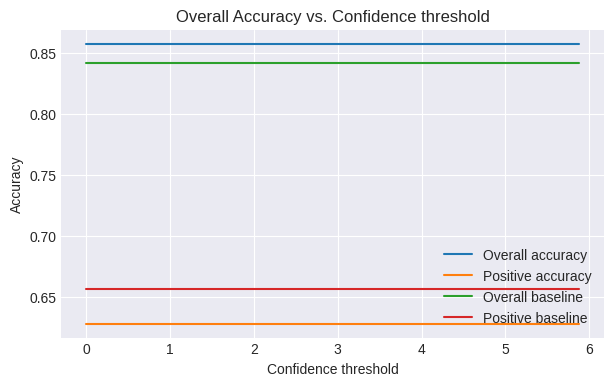

In [107]:
confidence = classifier.decision_function(X_test_proxy)
acc = []
pos_acc = []
to = []
scale = round(max(abs(confidence)), 0)
pos_total = sum([1 for i in range(len(y_pred_proxy)) if y_test_gold[i] == 1])
for k in range(num_steps):
    total, count = 0, 0
    pos_correct = 0
    for i in range(len(y_pred_proxy)):
        total += 1
        # if abs(confidence[i]) > k/num_steps*scale:
        #     label_we_use = y_pred_proxy[i]
        # else:
        label_we_use = y_test_proxy[i]
        
        if label_we_use == y_test_gold[i]:
            count += 1
        if y_test_gold[i] == 1 and label_we_use == y_test_gold[i]:
            pos_correct += 1

    acc.append(count / total)
    pos_acc.append(pos_correct / pos_total)


plt.plot([i/num_steps*scale for i in range(num_steps)], acc)
plt.plot([i/num_steps*scale for i in range(num_steps)], pos_acc)
plt.plot([i/num_steps*scale for i in range(num_steps)], [baseline_acc for _ in range(num_steps)])
plt.plot([i/num_steps*scale for i in range(num_steps)], [baseline_pos_acc for _ in range(num_steps)])
plt.legend(["Overall accuracy", "Positive accuracy", "Overall baseline", "Positive baseline"], loc='lower right')
plt.xlabel("Confidence threshold")
plt.ylabel("Accuracy")
plt.title("Overall Accuracy vs. Confidence threshold")
plt.gcf().set_size_inches(7, 4)
# plt.savefig('confidence.png', dpi=300)
plt.show()

### RQ - Change training data size

In [ ]:
accuracies = []
X_len = X_train_proxy.shape[0]
y_len = len(y_train_proxy)
for i in range(1, 80):
    # Split the data into training and test sets
    X_train_proxy_sampled, y_train_proxy_sampled = X_train_proxy[:min(i*10,X_len)], y_train_proxy[:min(i*10,y_len)]
    # Train a logistic regression classifier
    classifier = LogisticRegression()
    classifier.fit(X_train_proxy_sampled, y_train_proxy_sampled)
    

    # Make predictions on the test set
    y_pred_proxy_sampled = classifier.predict(X_test_proxy)

    # Evaluate the accuracy of the classifier
    accuracy = accuracy_score(y_test_proxy, y_pred_proxy_sampled)
    accuracies.append(accuracy)

plt.plot(np.arange(10, 800, 10), accuracies)
plt.xlabel("Number of samples")
plt.ylabel("Accuracy")
# set size
plt.gcf().set_size_inches(10, 5)
plt.savefig('accuracy.png', dpi=300)

### RQ - Manually adjust label distribution

In [ ]:
num_samples_idx=8
X_train_proxy_sampled, y_train_proxy_sampled = X_train_proxy[:min(num_samples_idx*10,X_len)], y_train_proxy[:min(num_samples_idx*10,y_len)]
# Train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train_proxy_sampled, y_train_proxy_sampled)

# Make predictions on the test set
y_pred_proxy_sampled = classifier.predict(X_test_proxy)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test_proxy, y_pred_proxy_sampled)
print("Accuracy:", accuracy)

# calculate accuracy for each class
pos_correct = 0
pos_total = 0
neg_correct = 0
neg_total = 0
for i in range(len(y_pred_proxy_sampled)):
    if y_test_proxy[i] == 1:
        pos_total += 1
        if y_pred_proxy_sampled[i] == y_test_proxy[i]:
            pos_correct += 1
    else:
        neg_total += 1
        if y_pred_proxy_sampled[i] == y_test_proxy[i]:
            neg_correct += 1

print("Positive accuracy: ", pos_correct / pos_total)
print("Negative accuracy: ", neg_correct / neg_total)

In [ ]:
import scipy
# put more negative samples into training data
new_negative_samples = []
new_positive_samples = []
for x, y in zip(X_train_proxy[:][min(num_samples_idx*10,X_len):], y_train_proxy[:][min(num_samples_idx*10,y_len):]):
    if y == 0:
        new_negative_samples = scipy.sparse.vstack([new_negative_samples, x]).tocsr()
    else:
        new_positive_samples = scipy.sparse.vstack([new_positive_samples, x]).tocsr()
print(new_negative_samples.shape, new_positive_samples.shape)

In [ ]:
new_accuracy, new_pos_accuracy, new_neg_accuracy = [accuracy], [pos_correct / pos_total], [neg_correct / neg_total]
num_new_samples = 10
for k in range(num_new_samples):
    X_train_proxy_sampled_plus = scipy.sparse.vstack([X_train_proxy[:min(num_samples_idx*10,X_len)], new_negative_samples[:k]])
    y_train_proxy_sampled_plus = y_train_proxy[:min(num_samples_idx*10,y_len)] + [0] * k

    # Train a logistic regression classifier
    classifier = LogisticRegression()
    classifier.fit(X_train_proxy_sampled_plus, y_train_proxy_sampled_plus)

    # Make predictions on the test set
    y_pred_proxy_sampled_plus = classifier.predict(X_test_proxy)

    # Evaluate the accuracy of the classifier
    accuracy = accuracy_score(y_test_proxy, y_pred_proxy_sampled_plus)
    new_accuracy.append(accuracy)

    # calculate accuracy for each class
    pos_correct = 0
    pos_total = 0
    neg_correct = 0
    neg_total = 0
    for i in range(len(y_pred_proxy_sampled_plus)):
        if y_test_proxy[i] == 1:
            pos_total += 1
            if y_pred_proxy_sampled_plus[i] == y_test_proxy[i]:
                pos_correct += 1
        else:
            neg_total += 1
            if y_pred_proxy_sampled_plus[i] == y_test_proxy[i]:
                neg_correct += 1
                
    new_pos_accuracy.append(pos_correct / pos_total)
    new_neg_accuracy.append(neg_correct / neg_total)

In [ ]:
# plot the accuracy changes as we adjust the number of samples
plt.plot(np.arange(num_samples_idx*10, num_samples_idx*10+num_new_samples+1), new_accuracy)
plt.plot(np.arange(num_samples_idx*10, num_samples_idx*10+num_new_samples+1), new_pos_accuracy)
plt.plot(np.arange(num_samples_idx*10, num_samples_idx*10+num_new_samples+1), new_neg_accuracy)
plt.xlabel("Number of samples")
plt.ylabel("Accuracy")
# set x-axis split
plt.xticks(np.arange(num_samples_idx*10, num_samples_idx*10+num_new_samples+1, 1))
# set size
plt.gcf().set_size_inches(10, 4)
plt.savefig('accuracy_change.png', dpi=300)
plt.legend(["Overall", "Positive", "Negative"])
print(new_accuracy)


## Training with Ground Truth

In [90]:

# Split the data into training and test sets
X_train_gold, X_test_gold, y_train_gold, y_test_gold = train_test_split(texts, labels, test_size=0.2, random_state=42)

# X_train_gold = vectorizer.fit_transform(X_train_gold)
# X_test_gold = vectorizer.transform(X_test_gold)

# Train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train_gold, y_train_gold)

# Make predictions on the test set
y_pred_gold = classifier.predict(X_test_gold)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test_gold, y_pred_gold)
print("Accuracy:", accuracy)


# calculate accuracy for each class
pos_correct = 0
pos_total = 0
neg_correct = 0
neg_total = 0
for i in range(len(y_pred_gold)):
    if y_test_gold[i] == 1:
        pos_total += 1
        if y_pred_gold[i] == y_test_gold[i]:
            pos_correct += 1
    else:
        neg_total += 1
        if y_pred_gold[i] == y_test_gold[i]:
            neg_correct += 1

print("Positive accuracy: ", pos_correct / pos_total)
print("Negative accuracy: ", neg_correct / neg_total)

Accuracy: 0.9075
Positive accuracy:  0.18604651162790697
Negative accuracy:  0.9943977591036415
